In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Problem 1

### First a sanity check to see if we generate graphs with $\left<k\right> = 10$

In [58]:
getVals = lambda x: list(dict(x).values())
getKeys = lambda x: list(dict(x).keys())

meanK = 10

G1 = nx.generators.erdos_renyi_graph(1000, meanK / 999)
G2 = nx.generators.watts_strogatz_graph(1000, 10, 0.1)
G3 = nx.generators.watts_strogatz_graph(1000, 10, 0.01)
G4 = nx.generators.barabasi_albert_graph(1000, 5)

[ np.mean(list(dict(G.degree).values())) for G in (G1, G2, G3, G4)]

[9.724, 10.0, 10.0, 9.95]

In [59]:
results = {
    "generator": [],
    "numNodes": [],
    "avgDeg": [],
    "2moment": [],
    "avgShortestPath": [],
    "avgClusterCoeff": [],
    "transitivity": [],
    "assortativity": []
}

def addResult(G, generator):
    results["generator"].append(generator)
    results["numNodes"].append(len(G.nodes))
    
    degs = np.array(getVals(G.degree))
    histX = np.arange(0, np.max(degs) + 1)
    histY = [ np.sum(degs == i) for i in histX ]
    histY = histY / np.sum(histY) # normalize
    moment1 = np.sum([ x*p      for x, p in zip(histX, histY) ])
    moment2 = np.sum([ (x**2)*p for x, p in zip(histX, histY) ])
    results["avgDeg"].append(moment1)
    results["2moment"].append(moment2)
    
    component = max(nx.components.connected_component_subgraphs(G), key=len)
    results["avgShortestPath"].append(nx.average_shortest_path_length(component))
    
    results["avgClusterCoeff"].append(nx.average_clustering(G))
    results["transitivity"].append(nx.transitivity(G))
    results["assortativity"].append(nx.assortativity.degree_assortativity_coefficient(G))

for i in range(30):
    print(i, end=" ")
    G1 = nx.generators.erdos_renyi_graph(1000, meanK / 999, seed=72+i)
    G2 = nx.generators.watts_strogatz_graph(1000, 10, 0.1, seed=72+i)
    G3 = nx.generators.watts_strogatz_graph(1000, 10, 0.01, seed=72+i)
    G4 = nx.generators.barabasi_albert_graph(1000, 5, seed=72+i)
    
    addResult(G1, "Erdos")
    addResult(G2, "Watts0.1")
    addResult(G3, "Watts0.01")
    addResult(G4, "Barabasi")

df = pd.DataFrame(results)
df

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

,generator,numNodes,avgDeg,2moment,avgShortestPath,avgClusterCoeff,transitivity,assortativity
0,Erdos,1000,10.048,111.172,3.250414,0.010642,0.010621,-0.008713
1,Watts0.1,1000,10.000,100.858,4.525021,0.507541,0.498448,-0.010800
2,Watts0.01,1000,10.000,100.070,10.656440,0.653831,0.652959,-0.000707
3,Barabasi,1000,9.950,198.688,2.996623,0.037308,0.029597,-0.042608
4,Erdos,1000,9.884,107.356,3.270376,0.011277,0.010772,-0.002362
...,...,...,...,...,...,...,...,...
115,Barabasi,1000,9.950,212.056,2.968631,0.042497,0.030608,-0.061973
116,Erdos,1000,9.896,106.808,3.270501,0.008673,0.008544,0.018046
117,Watts0.1,1000,10.000,100.932,4.452855,0.496982,0.488145,-0.004748
118,Watts0.01,1000,10.000,100.068,10.681618,0.653909,0.653107,-0.006745


In [60]:
groups = df.groupby(by="generator")
mean = groups.mean()
std = groups.std()

### Mean:

In [61]:
mean

,numNodes,avgDeg,2moment,avgShortestPath,avgClusterCoeff,transitivity,assortativity
generator,,,,,,,
Barabasi,1000,9.950000,203.395867,2.980822,0.039911,0.029691,-0.058270
Erdos,1000,10.003867,109.985200,3.255601,0.010142,0.010088,-0.002255
Watts0.01,1000,10.000000,100.097600,9.052121,0.648064,0.646797,0.002152
Watts0.1,1000,10.000000,100.938533,4.445761,0.492419,0.483567,-0.010739


### Standard Deviation

In [62]:
std

,numNodes,avgDeg,2moment,avgShortestPath,avgClusterCoeff,transitivity,assortativity
generator,,,,,,,
Barabasi,0.0,1.277547e-15,6.020609,0.013834,0.003039,0.001184,0.009194
Erdos,0.0,1.289843e-01,2.733284,0.016547,0.000981,0.000935,0.012675
Watts0.01,0.0,1.189331e-15,0.017922,0.842908,0.003425,0.003650,0.010803
Watts0.1,0.0,1.277547e-15,0.053914,0.050624,0.007857,0.008176,0.016257


Degree distributions. Each row is:
1 - Erdos Renyi
2 - Watts-Strogatz p=0.01
3 - Watts-Strogatz p=0.1
4 - Barabasi-Albert



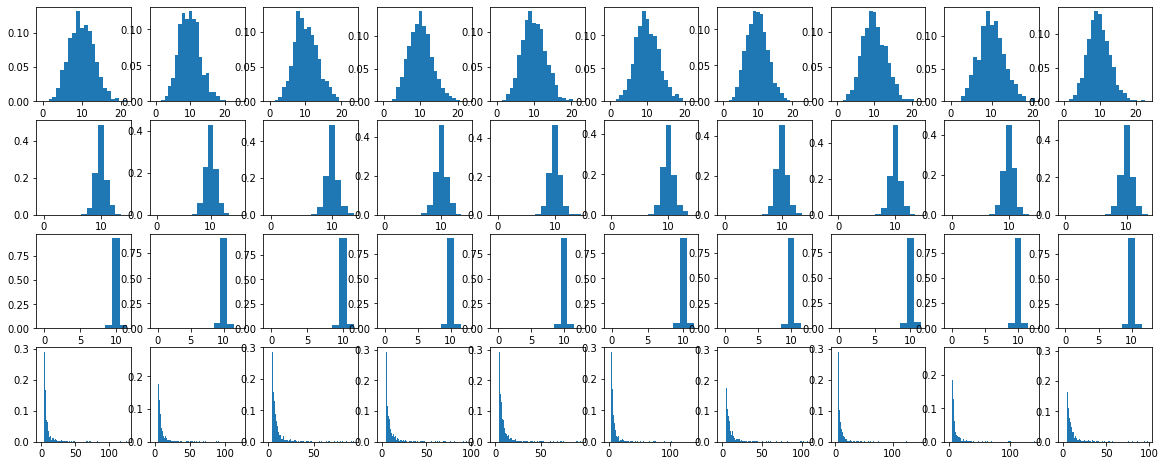

In [243]:
fig, ax = plt.subplots(nrows=4, ncols=10, figsize=(20, 8))

print("""Degree distributions. Each row is:
1 - Erdos Renyi
2 - Watts-Strogatz p=0.01
3 - Watts-Strogatz p=0.1
4 - Barabasi-Albert
""")

for i in range(10):
    G = nx.generators.erdos_renyi_graph(1000, meanK / 1000, seed=72+i)
    degs = getVals(G.degree)
    ax[0, i].hist(degs, bins=np.arange(-1, max(degs)+1) + 0.5, density=True)
    
for i in range(10):
    G = nx.generators.watts_strogatz_graph(1000, 10, 0.1, seed=72+i)
    degs = getVals(G.degree)
    ax[1, i].hist(degs, bins=np.arange(-1, max(degs)+1) + 0.5, density=True)

for i in range(10):
    G = nx.generators.watts_strogatz_graph(1000, 10, 0.01, seed=72+i)
    degs = getVals(G.degree)
    ax[2, i].hist(degs, bins=np.arange(-1, max(degs)+1) + 0.5, density=True)

for i in range(10):
    G = nx.generators.barabasi_albert_graph(1000, 5, seed=72+i)
    degs = getVals(G.degree)
    ax[3, i].hist(degs, bins=np.arange(-1, max(degs)+1) + 0.5, density=True)

### We see that Erdos-Renyi and Watts-Strogatz have degree distributions of similar shape, and they are not scale free. Barabasi-Albert is the only scale-free model here.

### We see high clustering coefficients and transitivity in both Watts-Strogatz models, so there must be a large number of triangles in such a graph. Despite this, the average shortest paths here were larger than I expected: the network is highly clustered, but the average distance is still quite high. 

### A larger second moment for the Barabasi graph is observed. This reflects the larger variance in scale-free graphs. On the other hand, the second moments for both the Watts graphs are very similar (the variance would be almost 0); I expected them to be different and larger.

### Finally, all model showed assortativity near 0, reflecting their random nature. If we wanted the assortativity to be within a specific range, we would need to employ a model specific for this purpose.

# Problem 2

Text(0, 0.5, 'Nodes in Giant Component')

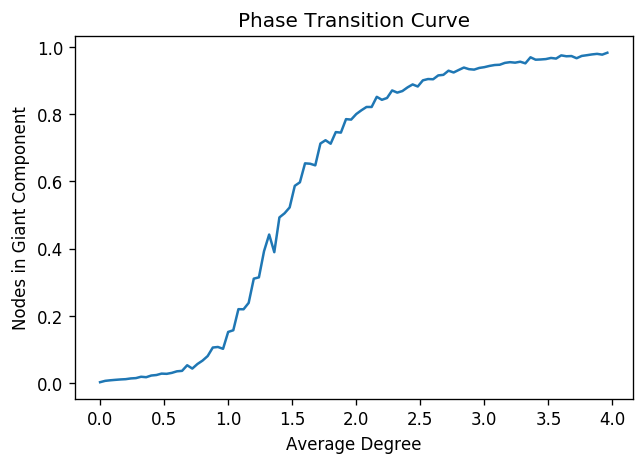

In [298]:
y = []
x = np.arange(0, 4, step=4/100)

NNODES = 300

for avgDeg in x:
    aux = []
    for i in range(20):
        giantComp = max(nx.connected_component_subgraphs(nx.erdos_renyi_graph(NNODES, avgDeg / (NNODES-1))), key=len)
        aux.append(len(giantComp.nodes) / NNODES)
    y.append(np.mean(aux))

plt.figure(dpi=120)
plt.plot(x, y)
plt.title("Phase Transition Curve")
plt.xlabel("Average Degree")
plt.ylabel("Nodes in Giant Component")

(4,100) (4,200) (4,300) (4,400) (4,500) (4,600) (4,700) (4,800) (4,900) (4,1000) (10,100) (10,200) (10,300) (10,400) (10,500) (10,600) (10,700) (10,800) (10,900) (10,1000) (20,100) (20,200) (20,300) (20,400) (20,500) (20,600) (20,700) (20,800) (20,900) (20,1000) (30,100) (30,200) (30,300) (30,400) (30,500) (30,600) (30,700) (30,800) (30,900) (30,1000) 

Text(0.5, 0, 'dMax')

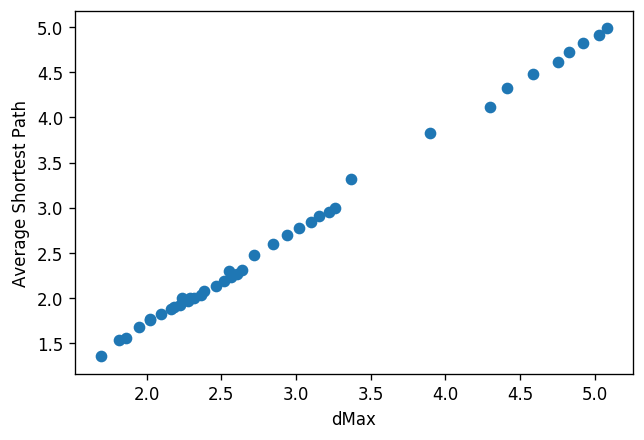

In [313]:
avgShortestPath = []
dMax = []

for avgDeg in (4, 10, 20, 30):
    for N in np.arange(100, 1001, step=100):
        print("({},{})".format(avgDeg, N), end=" ")
        avgSP = 0
        dM = 0
        nIter = 10

        for i in range(nIter):
            giantComp = max(nx.connected_component_subgraphs(nx.erdos_renyi_graph(N, avgDeg / (N-1))), key=len)
            avgSP += nx.average_shortest_path_length(giantComp)
            dM += np.log(N) / np.log(avgDeg)

        avgShortestPath.append(avgSP / nIter)
        dMax.append(dM / nIter)

plt.figure(dpi=120)
plt.scatter(avgShortestPath, dMax, cmap="rainbow")
plt.ylabel("Average Shortest Path")
plt.xlabel("dMax")

### The points lie on the line $y = x$, which characterizes small-world networks (though this did not work for average degrees lower than 4 when I tried earlier).

# Problem 3

In [65]:
p = np.concatenate([
#    np.linspace(1e-4, 1e-3, num=10),
    np.linspace(1e-3, 1e-2, num=10),
    np.linspace(1e-2, 1e-1, num=10),
    np.linspace(1e-1, 1e-0, num=10)
])
    
avgPath = []
clustering = []

maxG = nx.watts_strogatz_graph(100, 10, 0)
maxAvgPath = nx.average_shortest_path_length(maxG)
maxClustering = nx.average_clustering(maxG)

for pi in p:
    print(np.round(pi, decimals=1), end=" ")
    
    graph = lambda p: nx.watts_strogatz_graph(100, 10, p)
    path  = lambda G: nx.average_shortest_path_length(G)
    clus  = lambda G: nx.average_clustering(G)
    
    avgPath.append(np.mean([path(graph(pi)) for i in range(10) ]) / maxAvgPath)
    clustering.append(np.mean([ clus(graph(pi)) for i in range(10) ]) / maxClustering)

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 

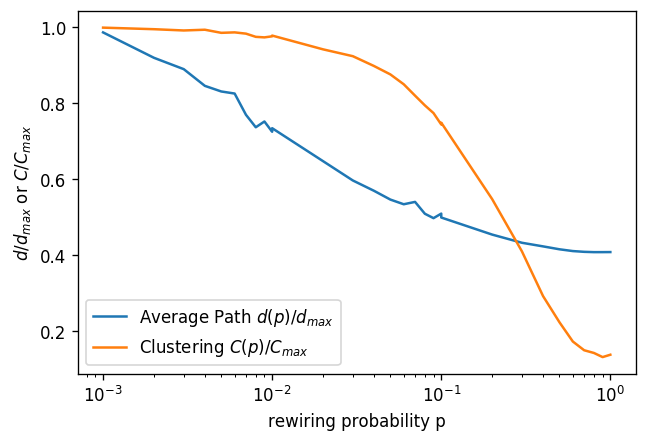

In [66]:
plt.figure(dpi=120)
plt.plot(p, avgPath, label="Average Path $d(p) /d_{max}$")
plt.plot(p, clustering, label="Clustering $C(p) / C_{max}$")
plt.xscale("log")
plt.xlabel("rewiring probability p")
plt.ylabel("$d/d_{max}$ or $C/C_{max}$")
plt.legend()

In [69]:
p = np.linspace(0, 1, num=100)
y = [] # second moment

for pi in p:
    print(np.round(pi, decimals=1), end=" ")

    graph = lambda p: nx.watts_strogatz_graph(100, 10, p)
    def var(G):
        degs = np.array(getVals(G.degree))
        histX = np.arange(0, np.max(degs) + 1)
        histY = [ np.sum(degs == i) for i in histX ]
        histY = histY / np.sum(histY) # normalize
        mean = np.sum([ x*p for x, p in zip(histX, histY) ])
        return np.sum([ (x**2)*p for x, p in zip(histX, histY) ]) - mean**2

    y.append(np.mean([var(graph(pi)) for i in range(10) ]) / maxAvgPath)

0.0 0.0 0.0 0.0 0.0 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 1.0 1.0 1.0 1.0 1.0 

Text(0.5, 0, 'rewiring probability p')

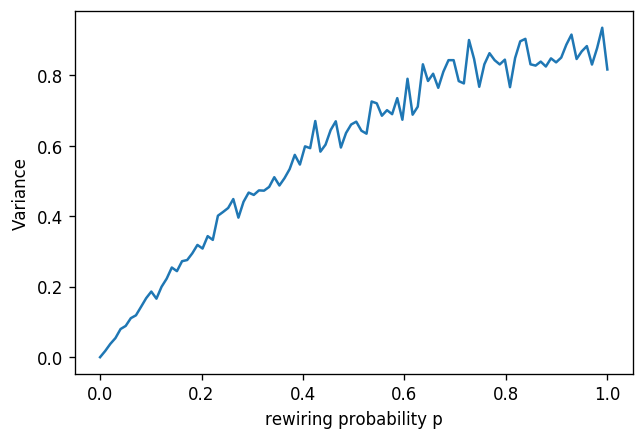

In [71]:
plt.figure(dpi=120)
plt.plot(p, y)
plt.ylabel("Variance")
plt.xlabel("rewiring probability p")

### We see that the variance of the degree distribution increased with $p$, as expected. Without any rewiring, the degrees are all the same, so variance is 0. The variance should increase as we increase the number of rewirings.

Text(0, 0.5, 'Probability')

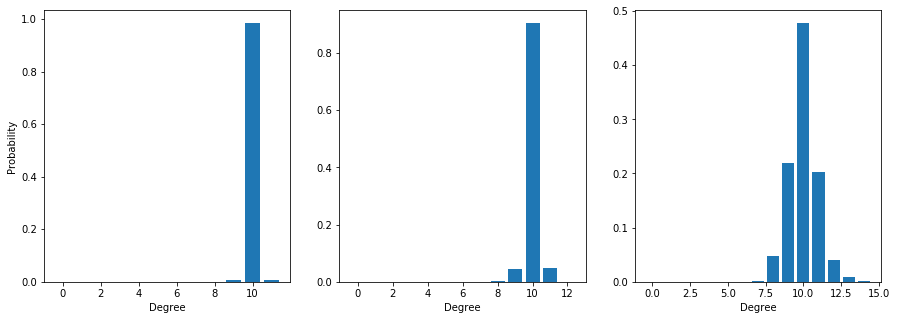

In [78]:
p = [0.001, 0.01, 0.1]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ax = np.ravel(ax)

for idx, pi in enumerate(p):
    G = nx.watts_strogatz_graph(1000, 10, pi)

    degs = np.array(getVals(G.degree))
    histX = np.arange(0, np.max(degs) + 1)
    histY = [ np.sum(degs == i) for i in histX ]
    histY = histY / np.sum(histY) # normalize
    ax[idx].bar(histX, histY)
    ax[idx].set_xlabel("Degree")
ax[0].set_ylabel("Probability")

0 0.001 0.01 0.1 1 

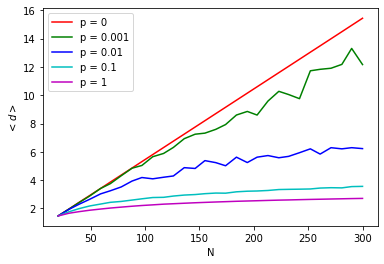

In [101]:
allN = np.int32(np.round(np.linspace(20, 300, num=30)))
colors = "rgbcmykw"

for idx, p in enumerate([0, 0.001, 0.01, 0.1, 1]):
    print(p, end=" ")
    y = []
    for N in allN:
        graph = lambda N, p: nx.watts_strogatz_graph(N, 10, p)
        path  = lambda G: nx.average_shortest_path_length(G)
        y.append(np.mean([path(graph(N, p)) for i in range(10) ]))
    plt.plot(allN, y, c=colors[idx], label="p = {}".format(p))

plt.xlabel("N")
plt.ylabel("$<d>$")
plt.legend()

### We see that the average shortest path tends to become shorter as we increase $p$. Of course this was expected, as the graph with $p = 0$ forms a very regular structure. Each node is only connected to its immediate neighbors in a circular structure; when we rewire the edges, we introduce shortcuts.